In [137]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

In [138]:
factor_list = ["reversal_1d", "reversal_1y", "skew_1m", "skew_1y", "kurt_1y", "illiquid_1d", 
               "maxRtn_22d", "salience", "vol_volume_5d", "vol_per_volume_5d", 
               "rank_cross_sec_5d", "vov_5d", "jump_5d", "bollinger_5d"]

In [139]:
class FactorCombination:
    def __init__(
        self, 
        factor_list: list, 
        factor_comb_method: str="LinearReg",
        start: str="2013-01-04", 
        end: str="2019-01-01", 
        factor_path: str = "factors",
        data_path: str = "data",
        rolling_pred_window: int = 1  # year
    ):
        self.factor_list = factor_list
        self.factor_path = factor_path
        self.factor_comb_method = factor_comb_method
        
        self.data_path = data_path
        self.rtn = pd.read_csv(f"{self.data_path}/rtn.csv", index_col = 0)
        
        self.rolling_pred_window = rolling_pred_window  # year
        self.start, self.end = start, end
        self.rolling_split = [f"{y}-01-01" for y in range(int(start[:4]) + 1, int(end[:4]) + 1)]
        
        self.savePath = f"factors_comb/{factor_comb_method}"
        if not os.path.exists(self.savePath):
            os.makedirs(self.savePath)
    
    def preprossData(self, data: pd.DataFrame) -> pd.DataFrame:
        data.fillna(method="ffill", limit=252, inplace=True)  # max one year
        return data.sub(data.mean(axis=1), axis='index').div(data.std(ddof=1, axis=1), axis='index')
    
    def readData(self):
        self.single_factor = []
        for i, factor_name in enumerate(self.factor_list):
            data = pd.read_csv(f"{self.factor_path}/{factor_name}.csv", index_col=0)
            data = self.preprossData(data)
            self.single_factor.append(data)
            
            if i == 0:
                self.num_dates, self.num_tickers = data.shape
                self.index = data.index
                self.columns = data.columns
    
    def stackFeature(self, start: str, end: str) -> pd.DataFrame:
            
        for i, factor_name in enumerate(self.factor_list):
            data = self.single_factor[i].loc[start:end]
            
            if i == 0:
                factor_concat = np.zeros(shape=(data.shape[0] * data.shape[1], len(self.factor_list)))
                
            factor_concat[:, i] = data.values.flatten()
        
        factor_concat = pd.DataFrame(factor_concat)
        factor_concat = factor_concat.where(factor_concat.notna(), factor_concat.mean(axis=1), axis=0)
        
        return factor_concat
    
    def getTarget(self, start: str, end: str) -> np.ndarray:
        rtn_period = self.rtn.loc[start: end]
        return rtn_period.values.flatten()
    
    def make_yX(self, X: pd.DataFrame, y: np.ndarray):
        yX = pd.concat([pd.DataFrame(y), X], axis=1)
        yX.dropna(how='any', axis=0, inplace=True)
        return yX
        
    
    def rolling_train_test(self) -> pd.DataFrame:
        pass
    
    
    def coef_sort(self, coef, features, col='beta'):
        coef_df = pd.DataFrame(coef, index=features, columns=[col])
        coef_df.sort_values(by=[col], inplace=True, ascending=True)
        return coef_df
    
    def plot_coef(self, coef_df):
        plt.figure(dpi=150, figsize=(5,10))
        plt.barh(
            y=list(range(coef_df.shape[0])), 
            width=coef_df.iloc[:,0].tolist(),
            color='lightskyblue',
            edgecolor='black',
            tick_label=coef_df.index.tolist(),
            alpha=0.3,
        )
        plt.title(f"feature importance")
        plt.savefig(f"{self.savePath}/coef.pdf")
        plt.show()
        plt.close()
    
    
    def save(self, prediction_df: pd.DataFrame):
        prediction_df.to_csv(f"{self.savePath}/factorComb_{self.factor_comb_method}.csv")
    
    def run(self):
        self.readData()
        prediction_df = self.rolling_train_test()
        self.save(prediction_df)
    
    
        

In [140]:
class FactorCombination_LinearRegression(FactorCombination):
    def __init__(
        self, 
        factor_list: list, 
        factor_comb_method: str="LinearReg",
        start: str="2013-01-04", 
        end: str="2019-01-01", 
        factor_path: str = "factors",
        data_path: str = "data",
        rolling_pred_window: int = 1  # year
    ):
        super().__init__(factor_list, factor_comb_method, start, end, factor_path, data_path, rolling_pred_window)
        self.R2 = []
        self.mse_train = []
        
    def rolling_train_test(self) -> pd.DataFrame:
        prediction_df = pd.DataFrame(index=self.index, columns=self.columns)
        
        for i, split in enumerate(self.rolling_split):
            print(f"Training {self.factor_comb_method}: {self.start} to {split}")
            X_train = self.stackFeature(start=self.start, end=split)
            y_train = self.getTarget(start=self.start, end=split)
            
            yX_train = self.make_yX(X=X_train, y=y_train)
            
            y_train = yX_train.iloc[:, 0]
            X_train = yX_train.iloc[:, 1:]
            lr = LinearRegression(fit_intercept=True)
            lr.fit(X_train, y_train)
            
            self.R2.append(lr.score(X_train, y_train))
            self.mse_train.append(mean_squared_error(y_train, lr.predict(X_train)))
            
            
            test_start = split
            test_end = self.rolling_split[i+1] if i < len(self.rolling_split) - 1 else self.end

            X_test = self.stackFeature(start=test_start, end=test_end)
            y_test = self.getTarget(start=test_start, end=test_end)
            
            y_pred_long = pd.DataFrame(index=X_test.index)
            
            yX_test = self.make_yX(X=X_test, y=y_test)
            
            y_pred_short = pd.DataFrame(lr.predict(yX_test.iloc[:, 1:]), index=yX_test.index)
            y_pred_long["y_pred"] = y_pred_short
            
            print(f"R2={self.R2[-1]}, mse_train={self.mse_train[-1]}")
            
            
            y_pred = y_pred_long.values.reshape(-1, self.num_tickers)
            prediction_df.loc[test_start: test_end] = y_pred
            
            if i == len(self.rolling_split) - 1:
                coef = self.coef_sort(coef=lr.coef_, features=self.factor_list, col='beta')
                self.plot_coef(coef)
        
        return prediction_df
            

        

Training LinearReg: 2013-01-04 to 2014-01-01
R2=0.000703925451728038, mse_train=0.0006114048405340059
Training LinearReg: 2013-01-04 to 2015-01-01
R2=0.00043054354719795906, mse_train=0.0004728522388621605
Training LinearReg: 2013-01-04 to 2016-01-01
R2=0.0003354379533750951, mse_train=0.00044589880228954363
Training LinearReg: 2013-01-04 to 2017-01-01
R2=0.0003640675592141429, mse_train=0.0004849475351355138
Training LinearReg: 2013-01-04 to 2018-01-01
R2=0.0002726630706919586, mse_train=0.00042863329619743316
Training LinearReg: 2013-01-04 to 2019-01-01
R2=0.0002109804597500986, mse_train=0.00041300636657768194
Training LinearReg: 2013-01-04 to 2020-01-01
R2=0.00025240130823445117, mse_train=0.0003922452753544953
Training LinearReg: 2013-01-04 to 2021-01-01
R2=0.00018423108747800399, mse_train=0.0004203332534282217


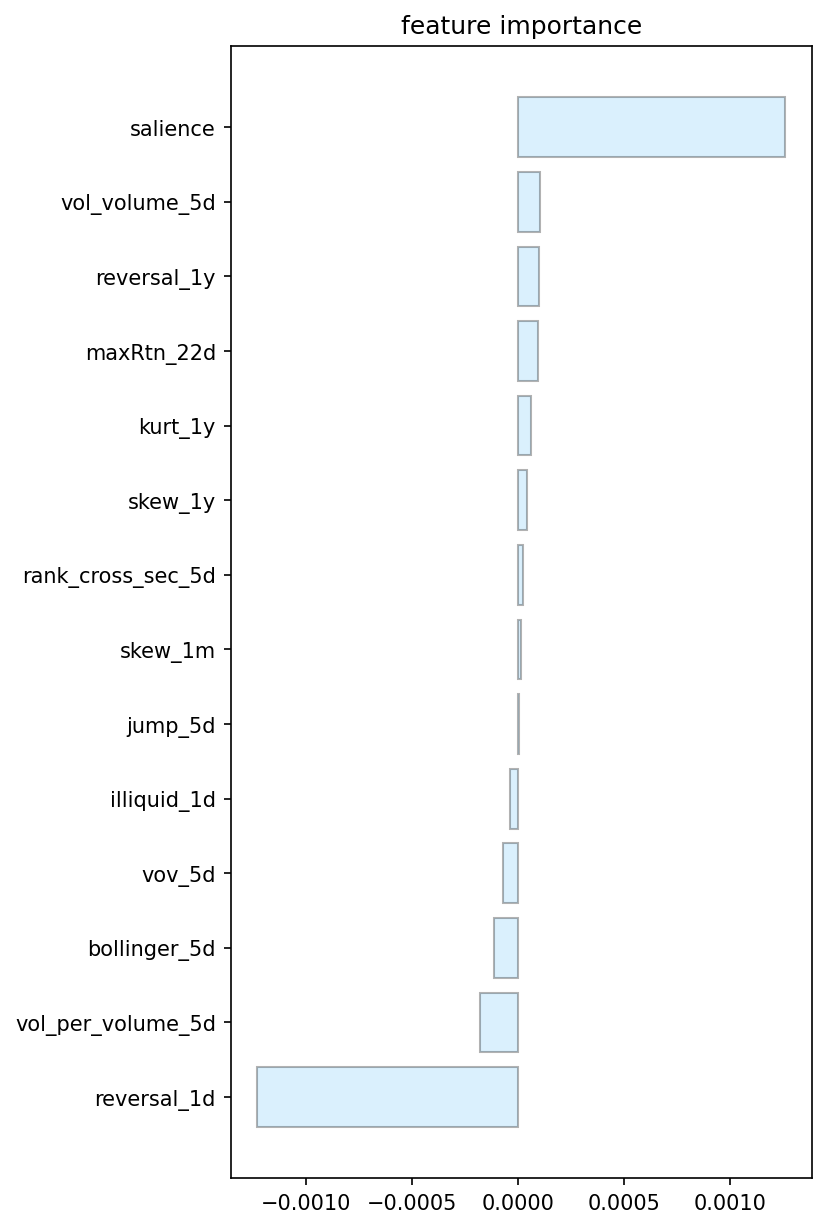

In [141]:
factorComb_LR = FactorCombination_LinearRegression(
    factor_list=factor_list, 
    factor_comb_method="LinearReg",
    start="2013-01-04", 
    end="2021-12-31"
)
factorComb_LR.run()

In [159]:
class FactorCombination_GradientBoostingMachine(FactorCombination):
    def __init__(
        self, 
        factor_list: list, 
        factor_comb_method: str="GradientBoost",
        start: str="2013-01-04", 
        end: str="2019-01-01", 
        factor_path: str = "factors",
        data_path: str = "data",
        rolling_pred_window: int = 1  # year
    ):
        super().__init__(factor_list, factor_comb_method, start, end, factor_path, data_path, rolling_pred_window)
        self.mse_train = []
        self.params = {
            'task': 'train', 
            'objective': 'regression',
            'boosting': 'gbdt',
            'metric': 'mean_squared_error',
            'n_estimators': 100,  # alias: num_iterations
            'learning_rate': 0.01,  # alias: shrinkage_rate
            'num_leaves': 31,  # max number of leaves in one tree
            'max_depth': 3, # max depth for tree. deal with over-fitting when data is small. Tree still grows leaf-wise, <= 0 means no limit
            'min_data_in_leaf': 20, # minimal number of data in one leaf. Can be used to deal with over-fitting
            'bagging_fraction': 0.9,  # randomly draw samples
            'feature_fraction': 0.9, # randomly sample features
            'verbose': -1
        }
 
        
    def rolling_train_test(self) -> pd.DataFrame:
        prediction_df = pd.DataFrame(index=self.index, columns=self.columns)
        
        for i, split in enumerate(self.rolling_split):
            print(f"Training {self.factor_comb_method}: {self.start} to {split}")
            X_train = self.stackFeature(start=self.start, end=split)
            y_train = self.getTarget(start=self.start, end=split)
            
            yX_train = self.make_yX(X=X_train, y=y_train)
            
            y_train = yX_train.iloc[:, 0]
            X_train = yX_train.iloc[:, 1:]
            
            lgb_train = lgb.Dataset(X_train, y_train, feature_name=self.factor_list)
            model = lgb.train(self.params, train_set=lgb_train)
            
            self.mse_train.append(mean_squared_error(y_train, model.predict(X_train)))
            
            
            test_start = split
            test_end = self.rolling_split[i+1] if i < len(self.rolling_split) - 1 else self.end

            X_test = self.stackFeature(start=test_start, end=test_end)
            y_test = self.getTarget(start=test_start, end=test_end)
            
            y_pred_long = pd.DataFrame(index=X_test.index)
            
            yX_test = self.make_yX(X=X_test, y=y_test)
            
            y_pred_short = pd.DataFrame(model.predict(yX_test.iloc[:, 1:]), index=yX_test.index)
            y_pred_long["y_pred"] = y_pred_short
            
            print(f"mse_train={self.mse_train[-1]}")
            
            
            y_pred = y_pred_long.values.reshape(-1, self.num_tickers)
            prediction_df.loc[test_start: test_end] = y_pred
            
            if i == len(self.rolling_split) - 1:
                coef = self.coef_sort(coef=model.feature_importance(), features=self.factor_list, col='feat_imp')
                self.plot_coef(coef)
        
        return prediction_df
            


Training GradientBoost: 2013-01-04 to 2014-01-01
mse_train=0.0006083040694552679
Training GradientBoost: 2013-01-04 to 2015-01-01
mse_train=0.00047153242153661083
Training GradientBoost: 2013-01-04 to 2016-01-01
mse_train=0.00044509208642172786
Training GradientBoost: 2013-01-04 to 2017-01-01
mse_train=0.0004844737493130277
Training GradientBoost: 2013-01-04 to 2018-01-01
mse_train=0.00042827174489210376
Training GradientBoost: 2013-01-04 to 2019-01-01
mse_train=0.00041263806733691583
Training GradientBoost: 2013-01-04 to 2020-01-01
mse_train=0.00039196234353902187
Training GradientBoost: 2013-01-04 to 2021-01-01
mse_train=0.00042009125908842485


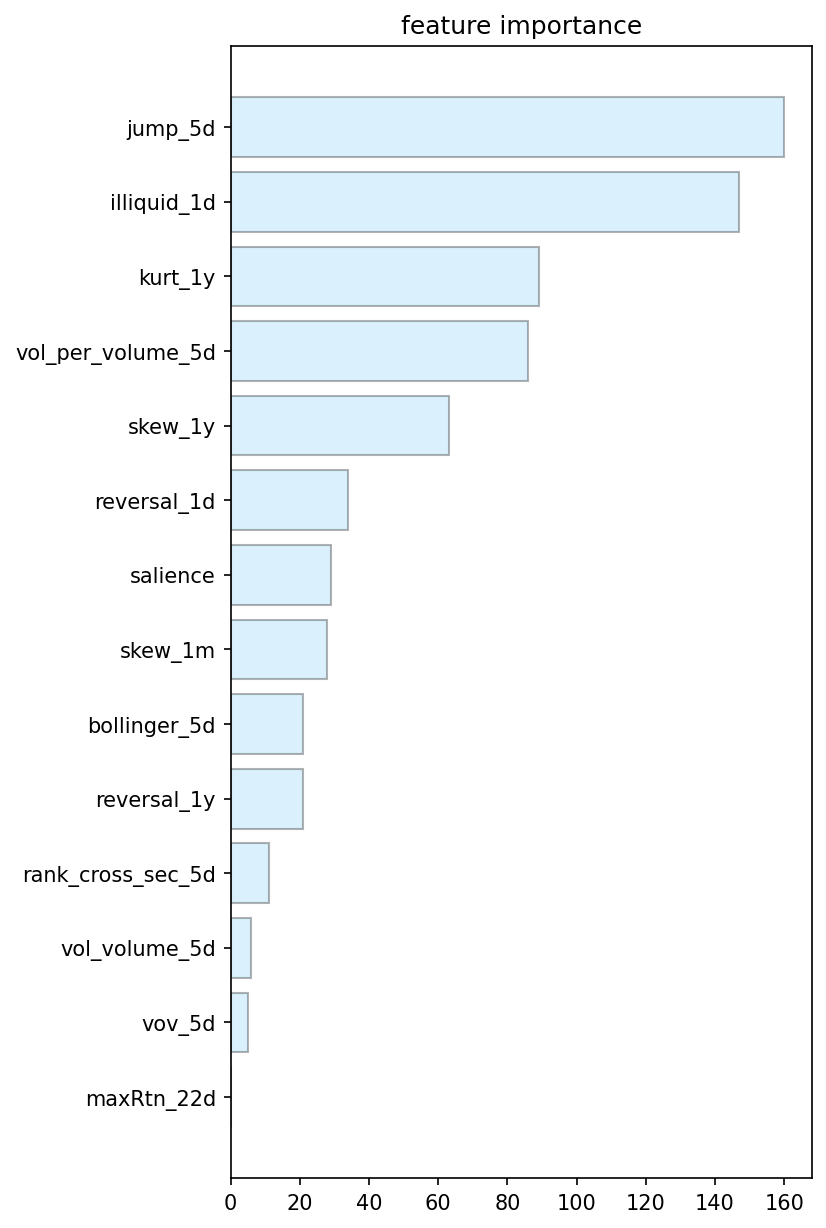

In [160]:
factorComb_GBM = FactorCombination_GradientBoostingMachine(
    factor_list=factor_list, 
    factor_comb_method="GradientBoost",
    start="2013-01-04", 
    end="2021-12-31"
)
factorComb_GBM.run()